In [43]:
import torch
import nltk
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from IPython import display

# An introduction to LSTM

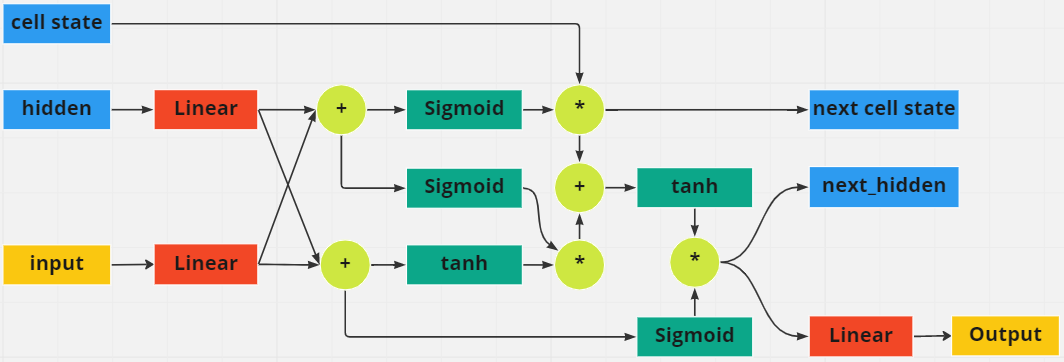

In [2]:
# The architecture of the LSTM is
display.Image('imgs/LSTM_cell.png')

In [3]:
# Just use some short sentence to show how the LSTM embed the sentence
sent = 'How are you today?'
tokens = nltk.word_tokenize(sent)
tokens_dict = {i:t for t, i in enumerate(tokens)}

emb_sent = []
for w in tokens:
    emb_sent.append(torch.tensor(tokens_dict[w], dtype=torch.float32).view(1, -1))
sent_size = len(emb_sent)

inputs = torch.cat(emb_sent).view(sent_size, 1, -1)
print(inputs)
print(inputs.shape)

tensor([[[0.]],

        [[1.]],

        [[2.]],

        [[3.]],

        [[4.]]])
torch.Size([5, 1, 1])


In [4]:
# Set the target tensor for a simple training
target = torch.tensor([0, 0, 1, 0, 0], dtype=torch.float32)

In [5]:
# Define parameters
hidden_dim = 10
out_dim = 5
n_layers = 1
batch_size = 1

# Define the LSTM cell 
# Feed the LSTM model with the whole input, thus the input size is 1 = inputs.shape[-1]
lstm = torch.nn.LSTM(inputs.shape[-1], hidden_dim, n_layers, batch_first=True)
linear = torch.nn.Linear(hidden_dim, out_dim)

# Initialize the hidden state and cell state
hidden_state = torch.randn(n_layers, sent_size, hidden_dim) 
cell_state = torch.randn(n_layers, sent_size, hidden_dim)
hidden = (hidden_state, cell_state)

# Feed the sentence to the lstm network
out, hidden = lstm(inputs, hidden)
# out = out.squeeze()[-1, :]
out = linear(out.squeeze()[-1, :])
print(target)
print(out)

tensor([0., 0., 1., 0., 0.])
tensor([-0.0049, -0.1212, -0.0966,  0.2330, -0.0797], grad_fn=<AddBackward0>)


In [6]:
params = [p for p in lstm.parameters()]
for p in params:
    p.requires_grad = True

n_params = sum(p.nelement() for p in params)
print(f'Total number of parameters {n_params}')

Total number of parameters 520


In [7]:
loss = torch.nn.functional.mse_loss(out, target)
print(f'Loss={loss.item():.4f}')

Loss=0.2556


In [8]:
for i in range(50):
    out, hidden = lstm(inputs, hidden)
    out = linear(out.squeeze()[-1, :])

    loss = torch.nn.functional.mse_loss(out, target)

    # Retain graph to continuously compute the gradient in this case
    for p in params:
        p.grad = None
    loss.backward(retain_graph=True)

    for p in params:
        p.data += -0.05 * p.grad

    loss = torch.nn.functional.mse_loss(out, target)
    print(f'{i+1}/{20}: Loss={loss.item():.4f}')

1/20: Loss=0.2041
2/20: Loss=0.1724
3/20: Loss=0.1582
4/20: Loss=0.1511
5/20: Loss=0.1466
6/20: Loss=0.1430
7/20: Loss=0.1397
8/20: Loss=0.1365
9/20: Loss=0.1335
10/20: Loss=0.1305
11/20: Loss=0.1276
12/20: Loss=0.1247
13/20: Loss=0.1220
14/20: Loss=0.1193
15/20: Loss=0.1167
16/20: Loss=0.1143
17/20: Loss=0.1119
18/20: Loss=0.1096
19/20: Loss=0.1074
20/20: Loss=0.1053
21/20: Loss=0.1033
22/20: Loss=0.1014
23/20: Loss=0.0996
24/20: Loss=0.0978
25/20: Loss=0.0961
26/20: Loss=0.0945
27/20: Loss=0.0929
28/20: Loss=0.0914
29/20: Loss=0.0899
30/20: Loss=0.0886
31/20: Loss=0.0872
32/20: Loss=0.0859
33/20: Loss=0.0847
34/20: Loss=0.0835
35/20: Loss=0.0823
36/20: Loss=0.0812
37/20: Loss=0.0801
38/20: Loss=0.0791
39/20: Loss=0.0781
40/20: Loss=0.0771
41/20: Loss=0.0761
42/20: Loss=0.0752
43/20: Loss=0.0743
44/20: Loss=0.0734
45/20: Loss=0.0726
46/20: Loss=0.0718
47/20: Loss=0.0710
48/20: Loss=0.0702
49/20: Loss=0.0694
50/20: Loss=0.0687


In [9]:
out


tensor([-0.1155,  0.0406,  0.5171,  0.1486,  0.2704], grad_fn=<AddBackward0>)

# An example of part-of-tagging from torch

In [10]:
training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]

In [11]:
words = []
tags = []
for s, t in training_data:
    words += s
    tags += t

words = list(set(words))
tags = list(set(tags))

word_to_ix = {w:i for i, w in enumerate(words)}
tag_to_ix = {t:i for i, t in enumerate(tags)}
print(word_to_ix)
print(tag_to_ix)

ix_to_tag = {i:t for t, i in tag_to_ix.items()}

{'The': 0, 'dog': 1, 'ate': 2, 'read': 3, 'book': 4, 'apple': 5, 'that': 6, 'Everybody': 7, 'the': 8}
{'V': 0, 'NN': 1, 'DET': 2}


In [12]:
# define a class for applying the model
class LSTMTagger(nn.Module):

    def __init__(self, emb_dim, hidden_dim, vocab_size, out_dim):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, sent):
        embeds = self.embedding(sent)
        lstm_out, _ = self.lstm(embeds.view(len(sent), 1, -1))
        linear_out = self.linear(lstm_out.view(len(sent), -1))
        tag_score = F.log_softmax(linear_out, dim=1)
        return tag_score

In [13]:
EMBEDDING_DIM = 10
HIDDEN_DIM = 20
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [14]:
with torch.no_grad():
    sent = training_data[0][0] # Get the first sentence (an list of words)
    inputs = torch.tensor([word_to_ix[w] for w in sent], dtype=torch.long) # Encode
    print(model(inputs)) # Get the tag score without training 

tensor([[-1.2250, -1.1764, -0.9217],
        [-1.2049, -1.1549, -0.9540],
        [-1.2303, -1.1555, -0.9341],
        [-1.2552, -1.1171, -0.9474],
        [-1.2312, -1.1352, -0.9501]])


In [15]:
MAX_EPOCH = 200
for i in range(MAX_EPOCH):
    print(f'{i+1}/{MAX_EPOCH}:=====================')
    for sent, tag in training_data:
        loss = 0
        model.zero_grad()

        inputs = torch.tensor([word_to_ix[w] for w in sent], dtype=torch.long)
        targets = torch.tensor([tag_to_ix[w] for w in tag], dtype=torch.long)
        # print(targets)

        tag_scores = model(inputs)
        # print(tag_scores)

        loss = loss_function(tag_scores, targets)

        loss.backward()

        optimizer.step()
    
        print(f'Loss={loss.item()}')
    
    print()

1/200:=====================
Loss=1.0779136419296265
Loss=1.1387474536895752

2/200:=====================
Loss=1.0684795379638672
Loss=1.1222425699234009

3/200:=====================
Loss=1.0599242448806763
Loss=1.1069309711456299

4/200:=====================
Loss=1.0520923137664795
Loss=1.0926538705825806

5/200:=====================
Loss=1.0448485612869263
Loss=1.0792722702026367

6/200:=====================
Loss=1.0380772352218628
Loss=1.0666649341583252

7/200:=====================
Loss=1.0316789150238037
Loss=1.054726004600525

8/200:=====================
Loss=1.0255684852600098
Loss=1.043360710144043

9/200:=====================
Loss=1.0196737051010132
Loss=1.0324842929840088

10/200:=====================
Loss=1.013932704925537
Loss=1.0220197439193726

11/200:=====================
Loss=1.0082929134368896
Loss=1.0118969678878784

12/200:=====================
Loss=1.0027096271514893
Loss=1.0020513534545898

13/200:=====================
Loss=0.9971442222595215
Loss=0.9924242496490479

In [16]:
sample = training_data[1]
sent = sample[0]
tags = sample[1]

inputs = torch.tensor([word_to_ix[w] for w in sent], dtype=torch.long) 
pred_seq = model(inputs).argmax(1).tolist()
pred = [ix_to_tag[i] for i in pred_seq]

print(sample[1])
print(pred)

['NN', 'V', 'DET', 'NN']
['NN', 'V', 'DET', 'NN']


# A use case for time serise prediction

In [71]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [5]:
pd.read_csv('data/hourly_energy_consumption/AEP_hourly.csv')

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


### Data processing

In [14]:
os.listdir('data/hourly_energy_consumption')

['AEP_hourly.csv',
 'COMED_hourly.csv',
 'DAYTON_hourly.csv',
 'DEOK_hourly.csv',
 'DOM_hourly.csv',
 'DUQ_hourly.csv',
 'EKPC_hourly.csv',
 'est_hourly.paruqet',
 'FE_hourly.csv',
 'NI_hourly.csv',
 'PJME_hourly.csv',
 'PJMW_hourly.csv',
 'pjm_hourly_est.csv',
 'PJM_Load_hourly.csv']

In [38]:
# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
data_dir = 'data/hourly_energy_consumption'

label_scalers = {}

train_x = []
test_x = {}
test_y = {}

for file in os.listdir(data_dir): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "pjm_hourly_est.csv":
        continue
    
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv('{}/{}'.format(data_dir, file), parse_dates=[0])
    # Processing the time data into suitable input formats
    df['hour'] = df.apply(lambda x: x['Datetime'].hour,axis=1)
    df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
    df['month'] = df.apply(lambda x: x['Datetime'].month,axis=1)
    df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
    df = df.sort_values("Datetime").drop("Datetime",axis=1)
    
    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc
    
    # Define lookback period (window size) and split inputs/labels
    lookback = 90
    inputs = np.zeros((len(data) - lookback, lookback, df.shape[1]))
    labels = np.zeros(len(data) - lookback)
    
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)
    
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])

In [42]:
len(train_x)

980185

### Data spliting

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

In [79]:
BATCH_SIZE = 1024 # Set the batch size to 1024

# Convert the train data into a tensor
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Get batch using the torch.DataLoader
train_loader = DataLoader(
    dataset=train_data,   
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True, # Drop the last imcomplete batch if len(traindata) // batch_size != 0
    **kwargs # Copy the tensor to the GPU 
)

In [74]:
counter = 0
for x, label in train_loader:
    counter += 1
    print(f'batch {counter}: sample shape={x.shape}, label shape={label.shape}')

batch 1: sample shape=torch.Size([1024, 90, 5]), label shape=torch.Size([1024, 1])
batch 2: sample shape=torch.Size([1024, 90, 5]), label shape=torch.Size([1024, 1])
batch 3: sample shape=torch.Size([1024, 90, 5]), label shape=torch.Size([1024, 1])
batch 4: sample shape=torch.Size([1024, 90, 5]), label shape=torch.Size([1024, 1])
batch 5: sample shape=torch.Size([1024, 90, 5]), label shape=torch.Size([1024, 1])
batch 6: sample shape=torch.Size([1024, 90, 5]), label shape=torch.Size([1024, 1])
batch 7: sample shape=torch.Size([1024, 90, 5]), label shape=torch.Size([1024, 1])
batch 8: sample shape=torch.Size([1024, 90, 5]), label shape=torch.Size([1024, 1])
batch 9: sample shape=torch.Size([1024, 90, 5]), label shape=torch.Size([1024, 1])
batch 10: sample shape=torch.Size([1024, 90, 5]), label shape=torch.Size([1024, 1])
batch 11: sample shape=torch.Size([1024, 90, 5]), label shape=torch.Size([1024, 1])
batch 12: sample shape=torch.Size([1024, 90, 5]), label shape=torch.Size([1024, 1])
b

## LSTM model

In [108]:
class LSTMNet(nn.Module):
    """ Define the LSTM model """

    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2) -> None:
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.relu(out[:, -1])
        out = self.linear(out)
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

### Train the LSTM model with evaluation

In [104]:
print(next(iter(train_loader))[0].shape) # (batch_size, lookback_size ,features)

torch.Size([1024, 90, 5])


#### Train the GRU model

In [105]:
INPUT_DIM = next(iter(train_loader))[0].shape[2]
HIDDEN_DIM = 256
LR = 0.001
EPOCHS = 5

In [113]:
model = LSTMNet(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=1, n_layers=2)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [114]:
print("Starting Training of the LSTM model")

epoch_time = [] # For tracking the training time
lossi = []      # For tracking the training loss

for epoch in range(EPOCHS):

    h = model.init_hidden(BATCH_SIZE) # Initialize the hidden layer
    avg_loss = 0. # Initialize the average loss
    counter = 0   # Initialize the counter to index the batch

    start_time = time.perf_counter() # Start recording the time

    for x, label in train_loader:
        counter += 1

        # Convert the hidden into a tuple
        h = tuple([e.data for e in h]) 

        # Standard process of the training
        model.zero_grad()                                  # Initialize the gradient
        out, h = model(x.to(device).float(), h)            # Forward pass
        loss = criterion(out, label.to(device).float())    # Compute the loss
        lossi.append(loss.item())
        loss.backward()                                    # Backpropagation
        optimizer.step()                                   # Parameters update

        # Track the loss and the training state
        avg_loss += loss.item()
        if counter % 200 == 0:
            print(f'Epoch {epoch+1}... Step: {counter}/{len(train_loader)}... Average Loss: {avg_loss/counter}')

    # break

    end_time = time.perf_counter() # Finish the time recording

    print(f'Epoch {epoch+1}/{EPOCHS} Done, Total Loss: {avg_loss/len(train_loader)}')
    print(f'Total Time Elapsed: {str(end_time - start_time)} seconds')
    epoch_time.append(end_time - start_time)

print(f'Total training time: {str(sum(epoch_time))} s')


Starting Training of the LSTM model
Epoch 1... Step: 200/957... Average Loss: 0.008619191071484239
Epoch 1... Step: 400/957... Average Loss: 0.004851526546699461
Epoch 1... Step: 600/957... Average Loss: 0.0034435775101398273
Epoch 1... Step: 800/957... Average Loss: 0.0026854756510510925
Epoch 1/5 Done, Total Loss: 0.0022947310252206853
Total Time Elapsed: 61.56326540000009 seconds
Epoch 2... Step: 200/957... Average Loss: 0.0002523939470847836
Epoch 2... Step: 400/957... Average Loss: 0.00023219091483042575
Epoch 2... Step: 600/957... Average Loss: 0.00022210895556781907
Epoch 2... Step: 800/957... Average Loss: 0.00021316824100722442
Epoch 2/5 Done, Total Loss: 0.00020921611600670313
Total Time Elapsed: 62.63041859999976 seconds
Epoch 3... Step: 200/957... Average Loss: 0.0001655776448023971
Epoch 3... Step: 400/957... Average Loss: 0.00015809130942216144
Epoch 3... Step: 600/957... Average Loss: 0.000157262288533578
Epoch 3... Step: 800/957... Average Loss: 0.00015329613857829828
E

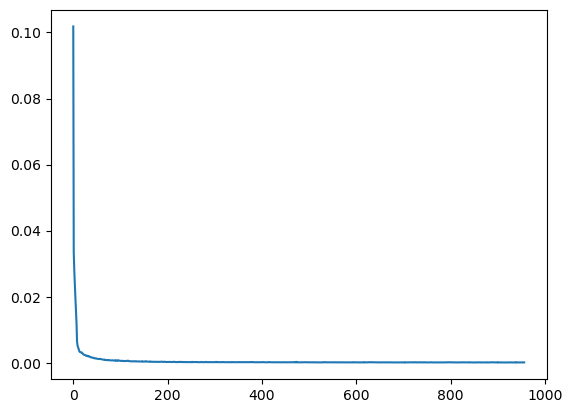

In [121]:
plt.plot(torch.tensor(lossi).view(957, -1).mean(1))

In [123]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    
    start_time = time.perf_counter()

    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))

    end_time = time.perf_counter()
    print("Evaluation Time: {}".format(end_time - start_time))

    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [125]:
lstm_outputs, lstm_targets, lstm_sMAPE = evaluate(model, test_x, test_y, label_scalers)

Evaluation Time: 2.2807941999999457
sMAPE: 0.24437593372285804%


In [132]:
len(lstm_outputs[2])

12118

In [140]:
target_files = []
for file in os.listdir(data_dir):
    if file[-4:] == ".csv" and file != "pjm_hourly_est.csv":
        target_files.append(file)

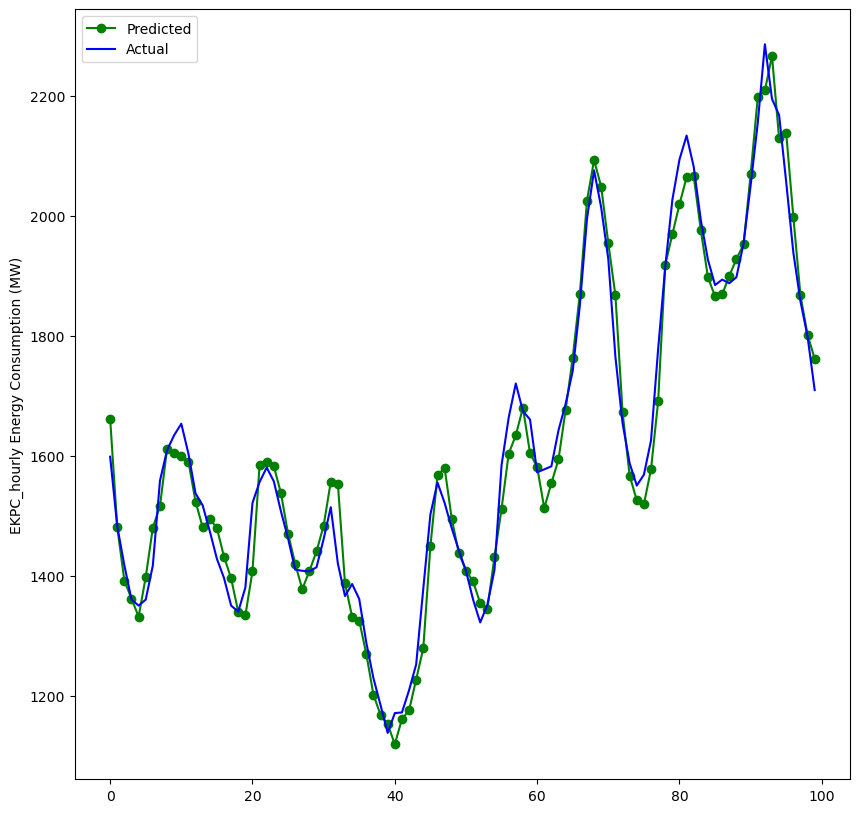

In [150]:
rand_idx = np.random.randint(0, len(lstm_outputs))
plt.figure(figsize=(10, 10))
plt.plot(lstm_outputs[6][:100], "-o", color="g", label="Predicted")
plt.plot(lstm_targets[6][:100], color="b", label="Actual")
plt.ylabel(str(target_files[6][:-4]) + ' Energy Consumption (MW)')
plt.legend()
plt.show()

## Save the model

In [149]:
torch.save(model, 'params/time_series/lstm_time_series_model')